**Fitness Q&A Model Training **

This notebook provides a comprehensive implementation for training a T5-based question-answering model specifically for fitness-related queries. 

Table of Contents

* Environment Setup
* Data Loading and Exploration
* Data Preprocessing
* Model Architecture
* Training Process
* Evaluation Metrics
* Interactive Chatbot
* Results and Analysis

In [1]:

"""
Package Installation and Environment Setup
"""

import subprocess
import sys
import os
from pathlib import Path

def install_required_packages():
    """Install all required packages with proper version management"""
    
    # Core packages with version constraints for compatibility
    required_packages = [
        "torch>=2.0.0",
        "transformers>=4.30.0", 
        "datasets>=2.12.0",
        "pandas>=1.5.0",
        "numpy>=1.21.0",
        "scikit-learn>=1.2.0",
        "evaluate>=0.4.0",
        "nltk>=3.8.0",
        "accelerate>=0.20.0",
        "sentencepiece>=0.1.99",
        "matplotlib>=3.5.0",
        "seaborn>=0.11.0",
        "tqdm>=4.64.0"
    ]
    
    print("🚀 Installing Required Packages...")
    print("=" * 50)
    
    for package in required_packages:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", package], 
                         check=True, capture_output=True)
            print(f" {package}")
        except subprocess.CalledProcessError as e:
            print(f" Failed to install {package}: {e}")
    
    print("\n Package installation completed!")

# Run installation
install_required_packages()

🚀 Installing Required Packages...
 torch>=2.0.0
 transformers>=4.30.0
 datasets>=2.12.0
 pandas>=1.5.0
 numpy>=1.21.0
 scikit-learn>=1.2.0
 evaluate>=0.4.0
 nltk>=3.8.0
 accelerate>=0.20.0
 sentencepiece>=0.1.99
 matplotlib>=3.5.0
 seaborn>=0.11.0
 tqdm>=4.64.0

 Package installation completed!


In [2]:
"""
Import All Required Libraries
"""

# Standard library imports
import os
import re
import logging
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

# Data manipulation and analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

# Machine learning and NLP
import torch
import torch.nn.functional as F
import nltk
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer, 
    T5ForConditionalGeneration, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)
import evaluate
from tqdm import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set up environment
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(" All libraries imported successfully!")
print(f" Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f" PyTorch version: {torch.__version__}")

2025-06-20 10:49:28.503137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750416568.696283      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750416568.756036      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 All libraries imported successfully!
 Using device: CUDA
 PyTorch version: 2.6.0+cu124


In [3]:
"""
Project Configuration and Constants
"""

class Config:
    """Configuration class containing all project parameters"""
    
    # Model configuration
    MODEL_NAME = "t5-small"
    MAX_INPUT_LENGTH = 512
    MAX_TARGET_LENGTH = 64
    
    # Training configuration
    TRAIN_BATCH_SIZE = 1
    EVAL_BATCH_SIZE = 2
    GRADIENT_ACCUMULATION_STEPS = 4
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 15
    WARMUP_STEPS = 200
    WEIGHT_DECAY = 0.01
    
    # Data configuration
    DATASET_NAME = "its-myrto/fitness-question-answers"
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Directories
    DATA_DIR = "processed_data"
    MODEL_DIR = "fitness_qa_model"
    LOGS_DIR = "logs"
    
    # Fitness keywords for filtering
    FITNESS_KEYWORDS = [
        'exercise', 'workout', 'fitness', 'nutrition', 'muscle', 'cardio',
        'strength', 'yoga', 'running', 'sleep', 'stress', 'recovery',
        'flexibility', 'balance', 'posture', 'hydration', 'motivation',
        'diet', 'weight', 'training', 'gym', 'health', 'stretch',
        'protein', 'calorie', 'endurance', 'aerobic', 'anaerobic'
    ]

# Create necessary directories
for directory in [Config.DATA_DIR, Config.MODEL_DIR, Config.LOGS_DIR]:
    Path(directory).mkdir(parents=True, exist_ok=True)

print(" Configuration loaded successfully!")
print(f" Working directories created: {Config.DATA_DIR}, {Config.MODEL_DIR}, {Config.LOGS_DIR}")

 Configuration loaded successfully!
 Working directories created: processed_data, fitness_qa_model, logs


In [4]:
"""
Loading the fitness Q&A dataset and perform initial exploration
"""

def load_fitness_dataset(dataset_name: str = Config.DATASET_NAME) -> pd.DataFrame:
    """Load fitness Q&A dataset from Hugging Face"""
    
    print(f" Loading dataset: {dataset_name}")
    
    try:
        # Load dataset
        dataset = load_dataset(dataset_name)
        df = dataset['train'].to_pandas()
        
        # Clean column names
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
        
        print(f" Dataset loaded successfully!")
        print(f" Dataset shape: {df.shape}")
        print(f" Columns: {list(df.columns)}")
        
        return df
        
    except Exception as e:
        logger.error(f"Failed to load dataset: {e}")
        raise

# Load the dataset
raw_dataset = load_fitness_dataset()

 Loading dataset: its-myrto/fitness-question-answers


README.md:   0%|          | 0.00/203 [00:00<?, ?B/s]

conversational_dataset.csv:   0%|          | 0.00/289k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/965 [00:00<?, ? examples/s]

 Dataset loaded successfully!
 Dataset shape: (965, 2)
 Columns: ['Question', 'Answer']


 DATASET EXPLORATION

 Dataset Overview:
   • Total samples: 965
   • Columns: ['Question', 'Answer']
   • Memory usage: 0.38 MB

 Sample Data:
                                            Question  \
0     can you recommend effective core ab exercises?   
1  how can i incorporate physical activity into m...   
2                why is physical activity important?   

                                              Answer  
0  sure! planks, bicycle crunches, and leg raises...  
1  take the stairs instead of the elevator whenev...  
2  regular physical activity can help maintain yo...  

❓ Missing Values:
   • Question: 0 (0.0%)
   • Answer: 0 (0.0%)


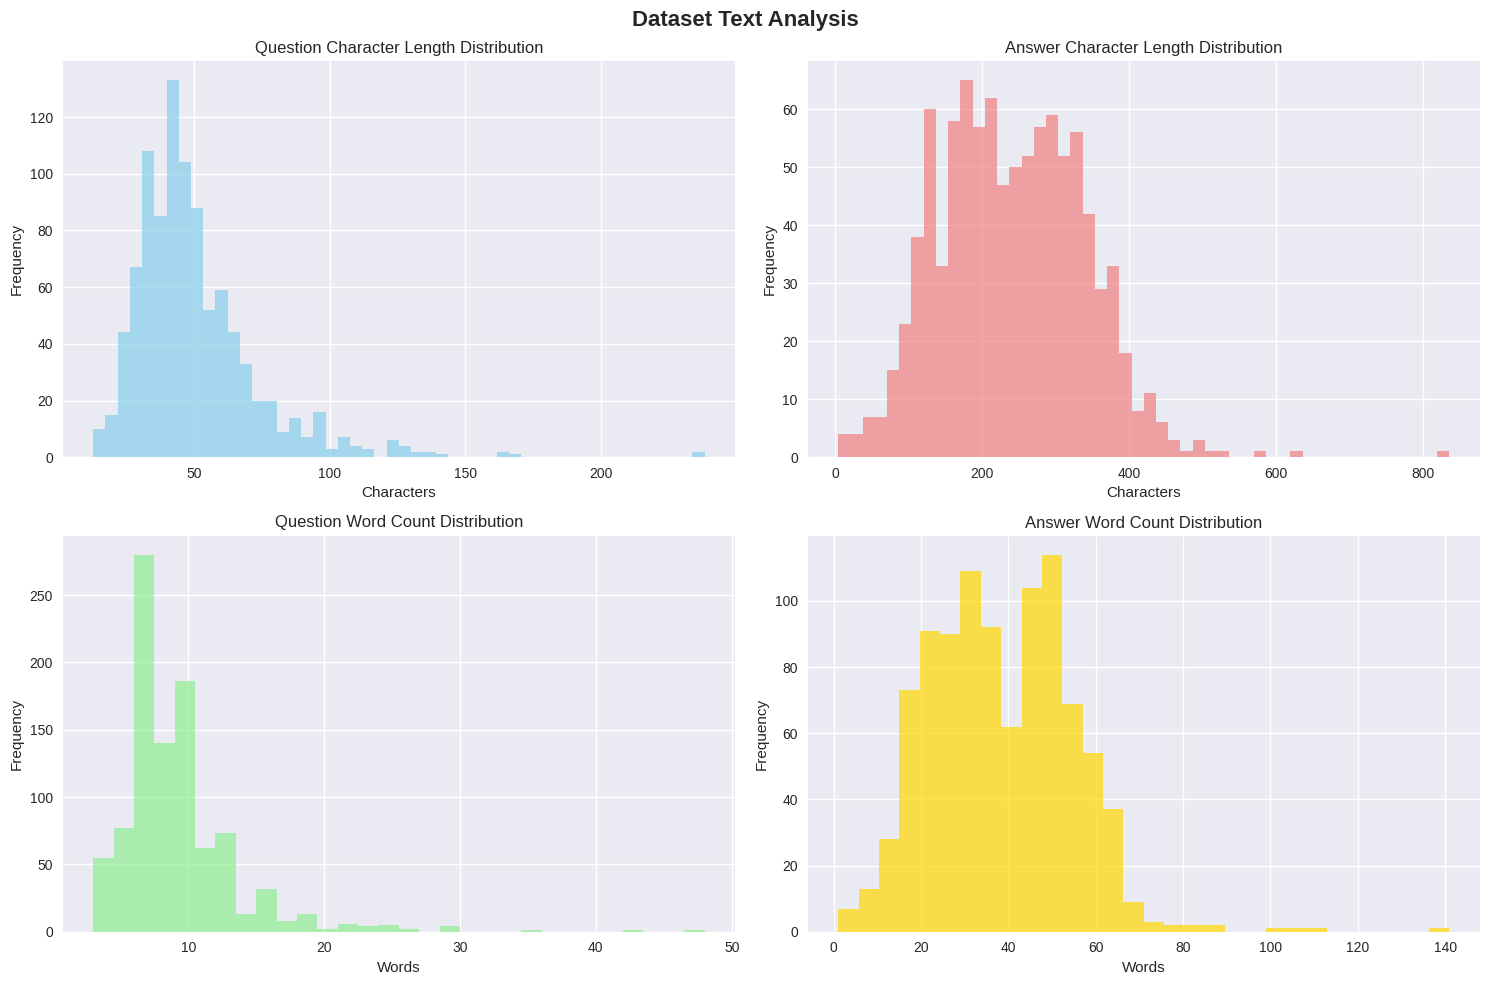


 Text Statistics:
   Questions:
     • Avg length: 50.3 chars
     • Avg words: 8.9
   Answers:
     • Avg length: 241.2 chars
     • Avg words: 38.2


In [5]:
"""
Exploring the dataset structure and visualizing key statistics
"""

def explore_dataset(df: pd.DataFrame) -> None:
    """Comprehensive dataset exploration with visualizations"""
    
    print(" DATASET EXPLORATION")
    print("=" * 50)
    
    # Basic information
    print(f"\n Dataset Overview:")
    print(f"   • Total samples: {len(df):,}")
    print(f"   • Columns: {list(df.columns)}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Display first few rows
    print(f"\n Sample Data:")
    print(df.head(3))
    
    # Check for missing values
    print(f"\n❓ Missing Values:")
    missing_values = df.isnull().sum()
    for col, missing in missing_values.items():
        print(f"   • {col}: {missing} ({missing/len(df)*100:.1f}%)")
    
    # Text length analysis
    question_col = 'Question'
    answer_col = 'Answer'
    
    if question_col in df.columns and answer_col in df.columns:
        df['question_length'] = df[question_col].astype(str).str.len()
        df['answer_length'] = df[answer_col].astype(str).str.len()
        df['question_words'] = df[question_col].astype(str).str.split().str.len()
        df['answer_words'] = df[answer_col].astype(str).str.split().str.len()
        
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Dataset Text Analysis', fontsize=16, fontweight='bold')
        
        # Question length distribution
        axes[0, 0].hist(df['question_length'], bins=50, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Question Character Length Distribution')
        axes[0, 0].set_xlabel('Characters')
        axes[0, 0].set_ylabel('Frequency')
        
        # Answer length distribution
        axes[0, 1].hist(df['answer_length'], bins=50, alpha=0.7, color='lightcoral')
        axes[0, 1].set_title('Answer Character Length Distribution')
        axes[0, 1].set_xlabel('Characters')
        axes[0, 1].set_ylabel('Frequency')
        
        # Question word count
        axes[1, 0].hist(df['question_words'], bins=30, alpha=0.7, color='lightgreen')
        axes[1, 0].set_title('Question Word Count Distribution')
        axes[1, 0].set_xlabel('Words')
        axes[1, 0].set_ylabel('Frequency')
        
        # Answer word count
        axes[1, 1].hist(df['answer_words'], bins=30, alpha=0.7, color='gold')
        axes[1, 1].set_title('Answer Word Count Distribution')
        axes[1, 1].set_xlabel('Words')
        axes[1, 1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print(f"\n Text Statistics:")
        print(f"   Questions:")
        print(f"     • Avg length: {df['question_length'].mean():.1f} chars")
        print(f"     • Avg words: {df['question_words'].mean():.1f}")
        print(f"   Answers:")
        print(f"     • Avg length: {df['answer_length'].mean():.1f} chars")
        print(f"     • Avg words: {df['answer_words'].mean():.1f}")

# Perform dataset exploration
explore_dataset(raw_dataset)

In [6]:
"""
Cell 6: Data Preprocessing Class
Purpose: Implement comprehensive data cleaning and preprocessing
"""

class FitnessDataProcessor:
    """Comprehensive data processor for fitness Q&A dataset"""
    
    def __init__(self):
        self.question_column = 'Question'
        self.answer_column = 'Answer'
        self.fitness_keywords = Config.FITNESS_KEYWORDS
    
    def clean_text(self, text: str) -> str:
        """Clean and normalize text data"""
        if not isinstance(text, str) or pd.isna(text):
            return ""
        
        # Basic cleaning
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
        text = re.sub(r'[^\w\s.,!?-]', '', text)  # Remove special chars
        
        # Remove very short texts
        if len(text.split()) < 3:
            return ""
        
        return text
    
    def is_valid_question(self, question: str) -> bool:
        """Check if text is a valid question"""
        if not question or len(question) < 10:
            return False
        
        # Check for alphabetic characters
        if not re.search(r'[a-zA-Z]', question):
            return False
        
        # Check for question indicators
        question_indicators = [
            'how', 'what', 'why', 'when', 'where', 'which', 'who',
            'can', 'should', 'do', 'does', 'is', 'are', 'will'
        ]
        
        return (question.endswith('?') or 
                any(question.startswith(word) for word in question_indicators))
    
    def is_fitness_related(self, text: str) -> bool:
        """Check if text is fitness-related based on keywords"""
        if not text:
            return False
        
        pattern = '|'.join(self.fitness_keywords)
        return bool(re.search(pattern, text, re.IGNORECASE))
    
    def remove_duplicates_and_invalid(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove duplicates and invalid entries"""
        print(" Cleaning dataset...")
        
        initial_count = len(df)
        
        # Remove duplicates
        df = df.drop_duplicates(subset=[self.question_column, self.answer_column])
        print(f"   • Removed {initial_count - len(df)} duplicates")
        
        # Remove missing values
        df = df.dropna(subset=[self.question_column, self.answer_column])
        print(f"   • Removed {initial_count - len(df)} rows with missing values")
        
        # Clean text
        df[self.question_column] = df[self.question_column].apply(self.clean_text)
        df[self.answer_column] = df[self.answer_column].apply(self.clean_text)
        
        # Remove empty entries after cleaning
        df = df[(df[self.question_column] != "") & (df[self.answer_column] != "")]
        print(f"   • Removed {initial_count - len(df)} empty entries after cleaning")
        
        return df.reset_index(drop=True)
    
    def filter_fitness_content(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter for fitness-related content"""
        print("🏋️ Filtering fitness-related content...")
        
        initial_count = len(df)
        
        # Filter valid questions
        valid_questions = df[self.question_column].apply(self.is_valid_question)
        df = df[valid_questions]
        print(f"   • Kept {len(df)} valid questions")
        
        # Filter fitness-related content
        fitness_questions = df[self.question_column].apply(self.is_fitness_related)
        fitness_answers = df[self.answer_column].apply(self.is_fitness_related)
        fitness_mask = fitness_questions | fitness_answers
        
        df = df[fitness_mask]
        print(f"   • Kept {len(df)} fitness-related entries")
        print(f"   • Removed {initial_count - len(df)} non-fitness entries")
        
        return df.reset_index(drop=True)
    
    def process_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """Complete dataset processing pipeline"""
        print(" STARTING DATA PROCESSING PIPELINE")
        print("=" * 50)
        
        # Step 1: Remove duplicates and invalid entries
        df_cleaned = self.remove_duplicates_and_invalid(df)
        
        # Step 2: Filter fitness content
        df_filtered = self.filter_fitness_content(df_cleaned)
        
        print(f"\n✅ Processing complete!")
        print(f"   • Original dataset: {len(df):,} samples")
        print(f"   • Final dataset: {len(df_filtered):,} samples")
        print(f"   • Retention rate: {len(df_filtered)/len(df)*100:.1f}%")
        
        return df_filtered

# Initialize processor
data_processor = FitnessDataProcessor()

 STARTING DATA PROCESSING PIPELINE
 Cleaning dataset...
   • Removed 0 duplicates
   • Removed 0 rows with missing values
   • Removed 1 empty entries after cleaning
🏋️ Filtering fitness-related content...
   • Kept 956 valid questions
   • Kept 902 fitness-related entries
   • Removed 62 non-fitness entries

✅ Processing complete!
   • Original dataset: 965 samples
   • Final dataset: 902 samples
   • Retention rate: 93.5%


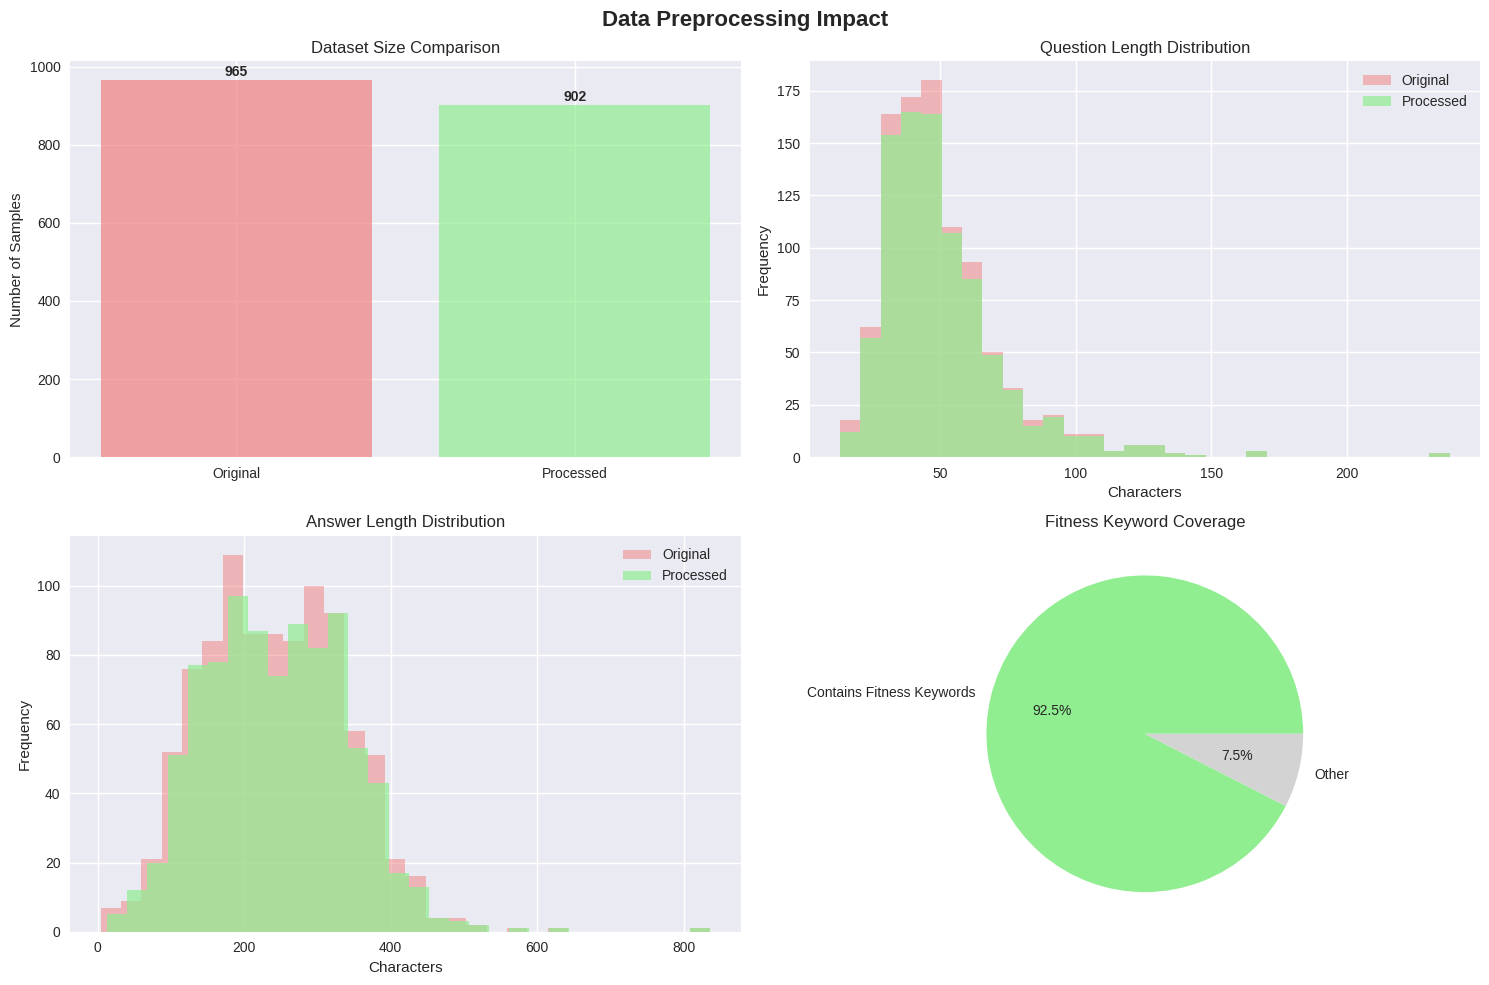

 Processed dataset saved to processed_data/processed_fitness_qa.csv


In [7]:
"""
Applying preprocessing and visualize the before/after comparison
"""

def visualize_preprocessing_results(original_df: pd.DataFrame, processed_df: pd.DataFrame) -> None:
    """Visualize the impact of preprocessing"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Data Preprocessing Impact', fontsize=16, fontweight='bold')
    
    # Dataset size comparison
    sizes = [len(original_df), len(processed_df)]
    labels = ['Original', 'Processed']
    colors = ['lightcoral', 'lightgreen']
    
    axes[0, 0].bar(labels, sizes, color=colors, alpha=0.7)
    axes[0, 0].set_title('Dataset Size Comparison')
    axes[0, 0].set_ylabel('Number of Samples')
    
    # Add value labels on bars
    for i, v in enumerate(sizes):
        axes[0, 0].text(i, v + max(sizes)*0.01, f'{v:,}', ha='center', fontweight='bold')
    
    # Question length comparison
    orig_q_len = original_df['Question'].astype(str).str.len()
    proc_q_len = processed_df['Question'].astype(str).str.len()
    
    axes[0, 1].hist(orig_q_len, bins=30, alpha=0.5, label='Original', color='lightcoral')
    axes[0, 1].hist(proc_q_len, bins=30, alpha=0.7, label='Processed', color='lightgreen')
    axes[0, 1].set_title('Question Length Distribution')
    axes[0, 1].set_xlabel('Characters')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    # Answer length comparison
    orig_a_len = original_df['Answer'].astype(str).str.len()
    proc_a_len = processed_df['Answer'].astype(str).str.len()
    
    axes[1, 0].hist(orig_a_len, bins=30, alpha=0.5, label='Original', color='lightcoral')
    axes[1, 0].hist(proc_a_len, bins=30, alpha=0.7, label='Processed', color='lightgreen')
    axes[1, 0].set_title('Answer Length Distribution')
    axes[1, 0].set_xlabel('Characters')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # Fitness keyword frequency
    fitness_keywords_count = sum(1 for text in processed_df['Question'] + ' ' + processed_df['Answer'] 
                                if any(keyword in text.lower() for keyword in Config.FITNESS_KEYWORDS[:10]))
    
    axes[1, 1].pie([fitness_keywords_count, len(processed_df) - fitness_keywords_count], 
                   labels=['Contains Fitness Keywords', 'Other'], 
                   autopct='%1.1f%%', 
                   colors=['lightgreen', 'lightgray'])
    axes[1, 1].set_title('Fitness Keyword Coverage')
    
    plt.tight_layout()
    plt.show()

# Process the dataset
processed_dataset = data_processor.process_dataset(raw_dataset)

# Visualize preprocessing results
visualize_preprocessing_results(raw_dataset, processed_dataset)

# Save processed dataset
processed_dataset.to_csv(f"{Config.DATA_DIR}/processed_fitness_qa.csv", index=False)
print(f" Processed dataset saved to {Config.DATA_DIR}/processed_fitness_qa.csv")

 Creating train-validation split...
 Dataset split completed:
   • Training set: 721 samples (79.9%)
   • Validation set: 181 samples (20.1%)


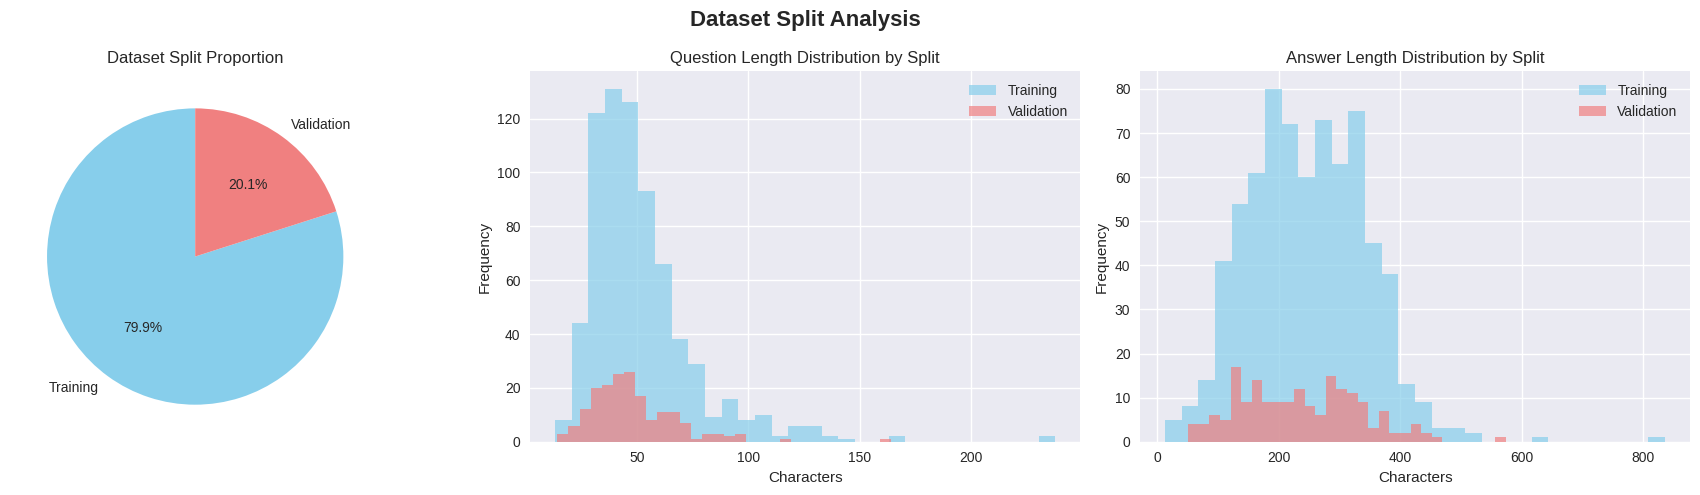

 Training dataset saved to processed_data/train_dataset.csv
 Validation dataset saved to processed_data/validation_dataset.csv


In [8]:
"""
Split dataset into training and validation sets with analysis
"""

def create_train_validation_split(df: pd.DataFrame, test_size: float = Config.TEST_SIZE) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Create train-validation split with stratification if possible"""
    
    print(" Creating train-validation split...")
    
    # Create train-validation split
    train_df, val_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=Config.RANDOM_STATE,
        shuffle=True
    )
    
    print(f" Dataset split completed:")
    print(f"   • Training set: {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
    print(f"   • Validation set: {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")
    
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

def visualize_dataset_split(train_df: pd.DataFrame, val_df: pd.DataFrame) -> None:
    """Visualize the dataset split characteristics"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Dataset Split Analysis', fontsize=16, fontweight='bold')
    
    # Split size visualization
    sizes = [len(train_df), len(val_df)]
    labels = ['Training', 'Validation']
    colors = ['skyblue', 'lightcoral']
    
    axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0].set_title('Dataset Split Proportion')
    
    # Question length comparison
    train_q_len = train_df['Question'].str.len()
    val_q_len = val_df['Question'].str.len()
    
    axes[1].hist(train_q_len, bins=30, alpha=0.7, label='Training', color='skyblue')
    axes[1].hist(val_q_len, bins=30, alpha=0.7, label='Validation', color='lightcoral')
    axes[1].set_title('Question Length Distribution by Split')
    axes[1].set_xlabel('Characters')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    # Answer length comparison
    train_a_len = train_df['Answer'].str.len()
    val_a_len = val_df['Answer'].str.len()
    
    axes[2].hist(train_a_len, bins=30, alpha=0.7, label='Training', color='skyblue')
    axes[2].hist(val_a_len, bins=30, alpha=0.7, label='Validation', color='lightcoral')
    axes[2].set_title('Answer Length Distribution by Split')
    axes[2].set_xlabel('Characters')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# Create train-validation split
train_dataset, validation_dataset = create_train_validation_split(processed_dataset)

# Visualize the split
visualize_dataset_split(train_dataset, validation_dataset)

# Save split datasets
train_dataset.to_csv(f"{Config.DATA_DIR}/train_dataset.csv", index=False)
validation_dataset.to_csv(f"{Config.DATA_DIR}/validation_dataset.csv", index=False)

print(f" Training dataset saved to {Config.DATA_DIR}/train_dataset.csv")
print(f" Validation dataset saved to {Config.DATA_DIR}/validation_dataset.csv")

In [9]:
"""
Initialize and configure the T5 model for fitness Q&A
"""

class T5FitnessModel:
    """T5 Model wrapper for fitness Q&A task"""
    
    def __init__(self, model_name: str = Config.MODEL_NAME):
        self.model_name = model_name
        self.max_input_length = Config.MAX_INPUT_LENGTH
        self.max_target_length = Config.MAX_TARGET_LENGTH
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model and tokenizer
        self.tokenizer = None
        self.model = None
        
        print(f" Initializing T5 model: {model_name}")
        print(f" Device: {self.device}")
        
    def load_model_and_tokenizer(self):
        """Load pre-trained T5 model and tokenizer"""
        
        try:
            print(" Loading tokenizer...")
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            
            print(" Loading model...")
            self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
            
            # Enable gradient checkpointing for memory efficiency
            self.model.gradient_checkpointing_enable()
            
            # Move model to device
            self.model.to(self.device)
            
            print(f" Model loaded successfully!")
            print(f"   • Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"   • Trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad):,}")
            
            return True
            
        except Exception as e:
            logger.error(f"Failed to load model: {e}")
            return False
    
    def format_input(self, question: str, prompt_type: str = "instruct") -> str:
        """Format input question for T5 model"""
        
        if prompt_type == "instruct":
            return f"Answer this fitness question: {question}"
        elif prompt_type == "qa":
            return f"question: {question}"
        else:
            return question
    
    def create_training_dataset(self, df: pd.DataFrame) -> Dataset:
        """Convert pandas DataFrame to HuggingFace Dataset for training"""
        
        print(f" Creating training dataset from {len(df)} samples...")
        
        # Format inputs and targets
        inputs = []
        targets = []
        
        for _, row in df.iterrows():
            input_text = self.format_input(row['Question'])
            inputs.append(input_text)
            targets.append(row['Answer'])
        
        # Tokenize inputs
        input_encodings = self.tokenizer(
            inputs,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Tokenize targets
        target_encodings = self.tokenizer(
            targets,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Create dataset dictionary
        dataset_dict = {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': target_encodings['input_ids'].squeeze()
        }
        
        dataset = Dataset.from_dict(dataset_dict)
        
        print(f" Dataset created successfully!")
        print(f"   • Input shape: {dataset['input_ids'].shape}")
        print(f"   • Features: {list(dataset.features.keys())}")
        
        return dataset

# Initialize the model
fitness_model = T5FitnessModel()

# Load model and tokenizer
model_loaded = fitness_model.load_model_and_tokenizer()

if model_loaded:
    print("\n Model Architecture Summary:")
    print(f"   • Model: {Config.MODEL_NAME}")
    print(f"   • Input max length: {Config.MAX_INPUT_LENGTH}")
    print(f"   • Target max length: {Config.MAX_TARGET_LENGTH}")
    print(f"   • Device: {fitness_model.device}")

 Initializing T5 model: t5-small
 Device: cuda
 Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

 Loading model...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

 Model loaded successfully!
   • Model parameters: 60,506,624
   • Trainable parameters: 60,506,624

 Model Architecture Summary:
   • Model: t5-small
   • Input max length: 512
   • Target max length: 64
   • Device: cuda


 Initializing T5 model: t5-small
 Device: cuda
 Loading tokenizer...
 Loading model...
 Model loaded successfully!
   • Model parameters: 60,506,624
   • Trainable parameters: 60,506,624

=== Model Architecture Visualization ===


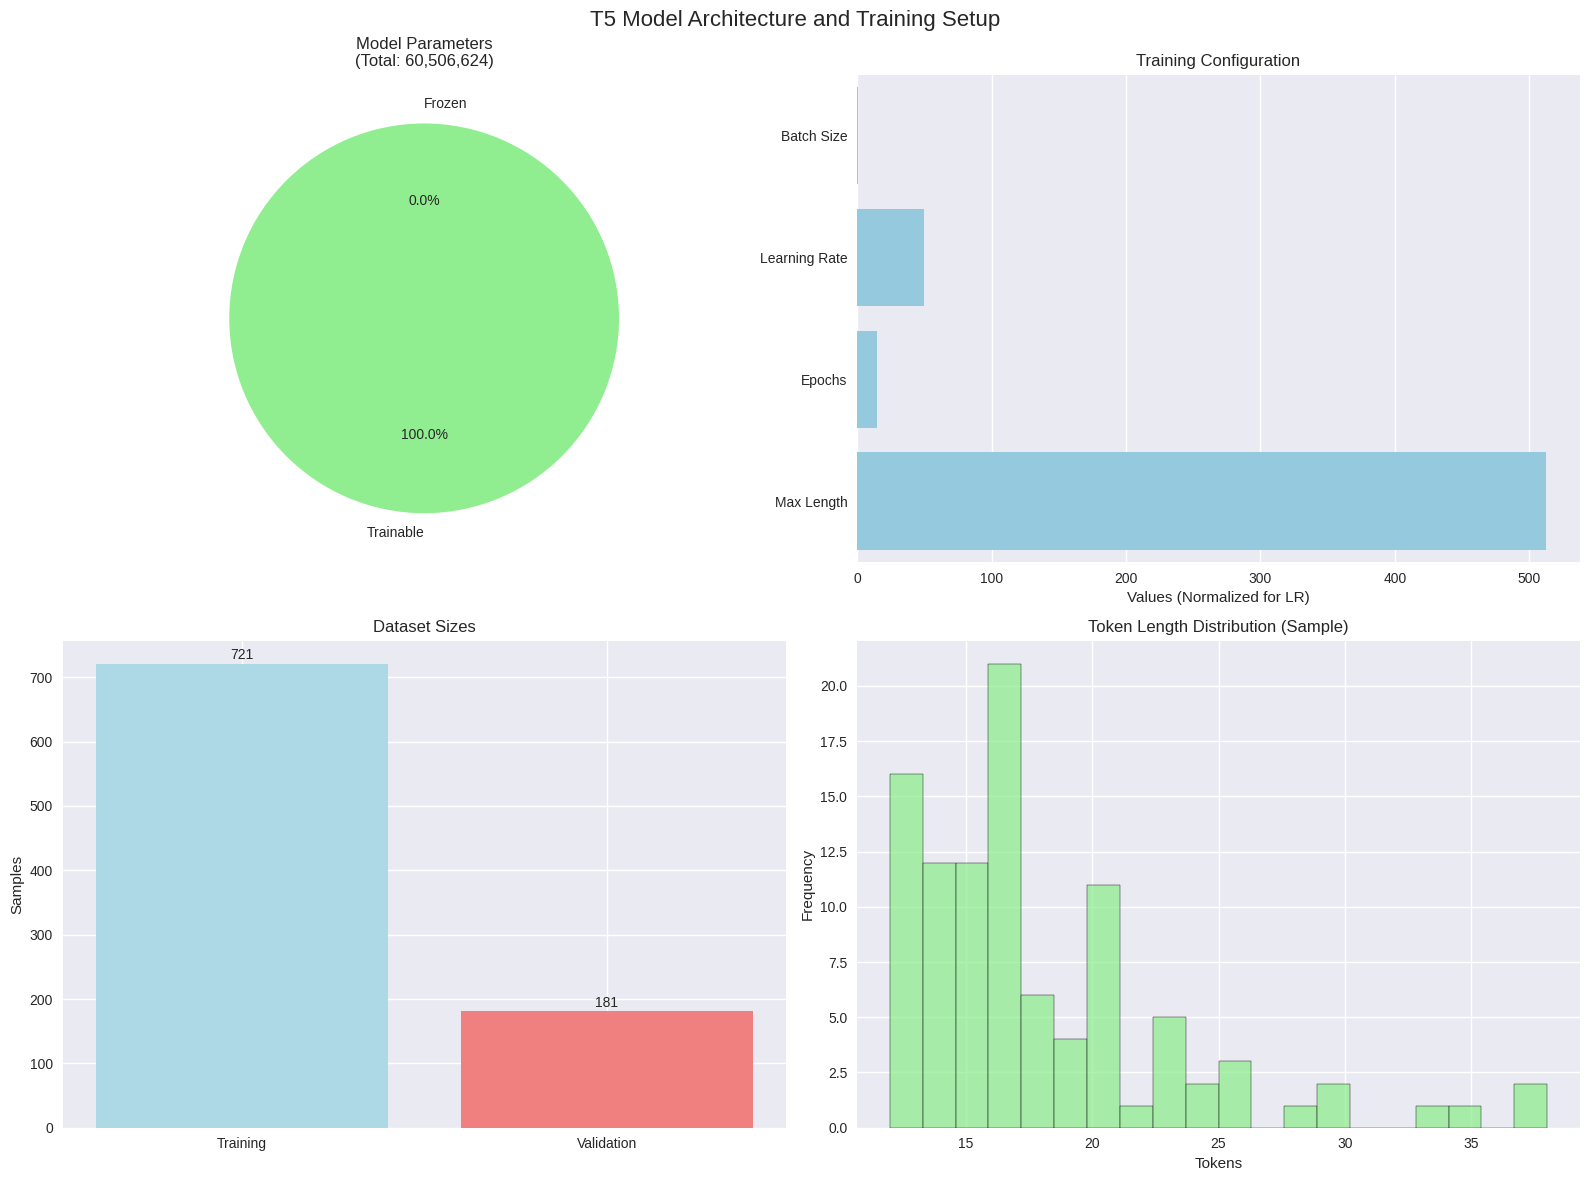

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pandas as pd

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def visualize_model_architecture(fitness_model: T5FitnessModel, train_df: pd.DataFrame) -> None:
    """
    Visualize T5 model architecture and training setup, including token length distribution.
    
    Args:
        fitness_model: Initialized T5FitnessModel instance.
        train_df: Training DataFrame for token analysis.
    """
    print("\n=== Model Architecture Visualization ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('T5 Model Architecture and Training Setup', fontsize=16)
    
    # Model parameters
    total_params = sum(p.numel() for p in fitness_model.model.parameters())
    trainable_params = sum(p.numel() for p in fitness_model.model.parameters() if p.requires_grad)
    
    axes[0, 0].pie([trainable_params, total_params - trainable_params], 
                   labels=['Trainable', 'Frozen'], autopct='%1.1f%%', 
                   colors=['lightgreen', 'lightgray'], startangle=90)
    axes[0, 0].set_title(f'Model Parameters\n(Total: {total_params:,})')
    
    # Training configuration
    config_items = ['Batch Size', 'Learning Rate', 'Epochs', 'Max Length']
    config_values = [Config.TRAIN_BATCH_SIZE, Config.LEARNING_RATE * 1e6, Config.NUM_EPOCHS, Config.MAX_INPUT_LENGTH]
    
    sns.barplot(x=config_values, y=config_items, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Training Configuration')
    axes[0, 1].set_xlabel('Values (Normalized for LR)')
    
    # Dataset sizes
    dataset_sizes = [len(train_df), len(pd.read_csv(f"{Config.DATA_DIR}/validation_dataset.csv"))]
    axes[1, 0].bar(['Training', 'Validation'], dataset_sizes, color=['lightblue', 'lightcoral'])
    axes[1, 0].set_title('Dataset Sizes')
    axes[1, 0].set_ylabel('Samples')
    for i, v in enumerate(dataset_sizes):
        axes[1, 0].text(i, v + max(dataset_sizes)*0.01, f'{v:,}', ha='center')
    
    # Token length distribution
    sample_questions = train_df['Question'].head(100)
    token_lengths = [
        len(fitness_model.tokenizer.encode(fitness_model.format_input(q)))
        for q in sample_questions
    ]
    
    sns.histplot(token_lengths, bins=20, ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Token Length Distribution (Sample)')
    axes[1, 1].set_xlabel('Tokens')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(f"{Config.LOGS_DIR}/model_architecture.png")
    plt.show()
    logger.info(f"Model visualization saved to {Config.LOGS_DIR}/model_architecture.png")

if __name__ == "__main__":
    fitness_model = T5FitnessModel()
    fitness_model.load_model_and_tokenizer()
    train_dataset = pd.read_csv(f"{Config.DATA_DIR}/train_dataset.csv")
    visualize_model_architecture(fitness_model, train_dataset)

 Starting T5 Fitness Model Training

=== T5 Model Setup ===
 Model loaded: 60,506,624 parameters

 Loading datasets...
Training samples: 721
Validation samples: 181

===  Model Training ===

 Creating training dataset...
 Dataset created: 721 samples

 Creating training dataset...
 Dataset created: 181 samples


Step,Training Loss,Validation Loss
200,3.254500,2.657473
400,2.778400,2.445330
600,2.638200,2.397707
800,2.456400,2.369450
1000,2.472000,2.348592
1200,2.492600,2.333203
1400,2.473500,2.324093
1600,2.446800,2.316422
1800,2.441800,2.309017
2000,2.339300,2.304386


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed successfully
 Saving model and tokenizer...
 Model and tokenizer saved successfully to fitness_qa_model/final


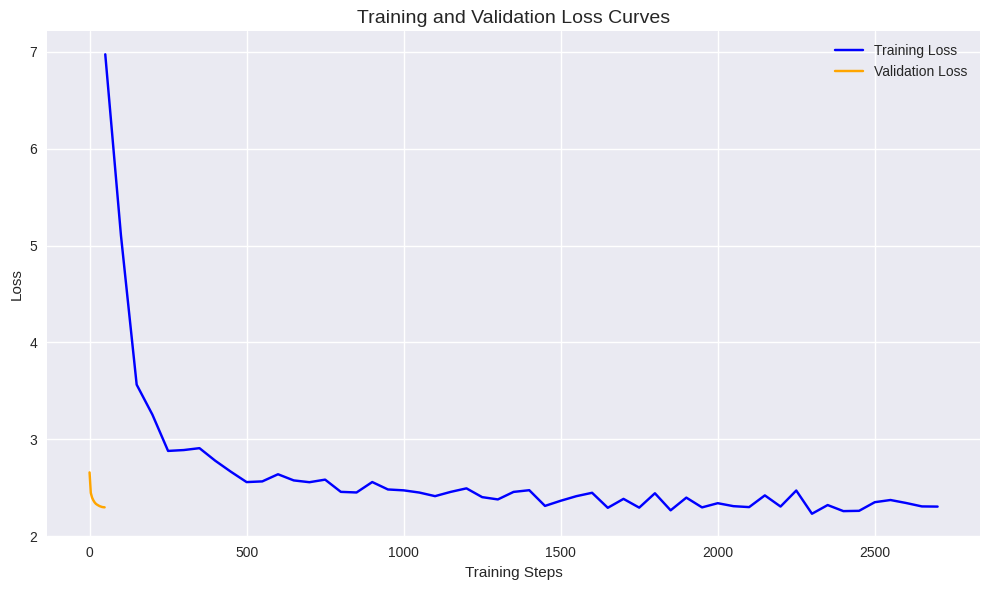


🎉 Training pipeline completed successfully!
Final model saved to: fitness_qa_model/final


In [30]:
import torch
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Tuple
from datasets import Dataset
import pandas as pd
import os
import shutil
import yaml

# Memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Fallback Config class
try:
    from configuration import Config
except ModuleNotFoundError:
    class Config:
        # Update to absolute path if directory issues persist, e.g., "/absolute/path/to/fitness_qa_model"
        MODEL_NAME = "t5-small"
        MAX_INPUT_LENGTH = 512
        MAX_TARGET_LENGTH = 64
        TRAIN_BATCH_SIZE = 1
        EVAL_BATCH_SIZE = 2
        GRADIENT_ACCUMULATION_STEPS = 4
        LEARNING_RATE = 5e-5
        NUM_EPOCHS = 15
        WARMUP_STEPS = 200
        WEIGHT_DECAY = 0.01
        DATA_DIR = "processed_data"
        MODEL_DIR = "fitness_qa_model"
        LOGS_DIR = "logs"

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Inline T5FitnessModel class
class T5FitnessModel:
    def __init__(self, model_name: str = Config.MODEL_NAME):
        self.model_name = model_name
        self.max_input_length = Config.MAX_INPUT_LENGTH
        self.max_target_length = Config.MAX_TARGET_LENGTH
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = None
        self.model = None
        logger.info(f"Initializing T5 model: {model_name} on {self.device}")
    
    def load_model_and_tokenizer(self) -> bool:
        print("\n=== T5 Model Setup ===")
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
            self.model.gradient_checkpointing_enable()
            self.model.to(self.device)
            logger.info("Model and tokenizer loaded")
            print(f" Model loaded: {sum(p.numel() for p in self.model.parameters()):,} parameters")
            return True
        except Exception as e:
            logger.error(f"Failed to load model: {e}")
            return False
    
    def format_input(self, question: str) -> str:
        return f"Answer this fitness question: {question}"
    
    def create_training_dataset(self, df: pd.DataFrame) -> Dataset:
        print("\n Creating training dataset...")
        inputs = [self.format_input(row['Question']) for _, row in df.iterrows()]
        targets = [str(row['Answer']) for _, row in df.iterrows()]
        input_encodings = self.tokenizer(
            inputs, max_length=self.max_input_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        target_encodings = self.tokenizer(
            targets, max_length=self.max_target_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        dataset = Dataset.from_dict({
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': target_encodings['input_ids'].squeeze()
        })
        logger.info(f"Created dataset with {len(dataset)} samples")
        print(f" Dataset created: {len(dataset)} samples")
        return dataset

def plot_training_metrics(trainer: Trainer) -> None:
    """
    Plot training and validation loss curves.
    """
    log_history = trainer.state.log_history
    steps, train_loss, val_loss = [], [], []
    
    for log in log_history:
        if 'loss' in log:
            steps.append(log['step'])
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            val_loss.append(log['eval_loss'])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=steps[:len(train_loss)], y=train_loss, label='Training Loss', color='blue')
    if val_loss:
        val_steps = [s * (len(train_loss) // len(val_loss)) for s in range(len(val_loss))]
        sns.lineplot(x=val_steps, y=val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves', fontsize=14)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{Config.LOGS_DIR}/loss_curves.png")
    plt.show()
    logger.info(f"Loss curves saved to {Config.LOGS_DIR}/loss_curves.png")

def check_disk_space(path: str, required_space_mb: int = 1000) -> bool:
    """
    Check if enough disk space is available.
    """
    try:
        stat = shutil.disk_usage(path)
        free_mb = stat.free / (1024 ** 2)
        logger.info(f"Disk space at {path}: {free_mb:.2f} MB free")
        return free_mb >= required_space_mb
    except Exception as e:
        logger.error(f"Failed to check disk space: {e}")
        return False

def check_write_permission(path: str) -> bool:
    """
    Check if directory is writable.
    """
    try:
        test_file = os.path.join(path, 'test_write.txt')
        with open(test_file, 'w') as f:
            f.write('test')
        os.remove(test_file)
        logger.info(f"Write permission verified for {path}")
        return True
    except Exception as e:
        logger.error(f"Failed to check write permission at {path}: {e}")
        return False

def clear_checkpoints(output_dir: str) -> None:
    """
    Clear existing checkpoints to avoid loading issues.
    """
    try:
        checkpoint_dirs = [d for d in os.listdir(output_dir) if d.startswith('checkpoint')]
        for d in checkpoint_dirs:
            shutil.rmtree(os.path.join(output_dir, d))
            logger.info(f"Removed checkpoint: {d}")
    except Exception as e:
        logger.error(f"Failed to clear checkpoints: {e}")

def verify_saved_model(final_model_path: str) -> bool:
    """
    Verify that the model was saved correctly by checking for required files.
    This function checks for both old and new model file formats.
    """
    required_files = ["config.json"]
    optional_tokenizer_files = ["tokenizer.json", "tokenizer_config.json", "special_tokens_map.json"]
    model_files = ["pytorch_model.bin", "model.safetensors"]  # Check for either format
    
    # Check for config file (always required)
    config_path = os.path.join(final_model_path, "config.json")
    if not os.path.exists(config_path):
        logger.error(f"Missing required file: config.json")
        return False
    
    # Check for model weights (either pytorch_model.bin or model.safetensors)
    model_file_found = False
    for model_file in model_files:
        model_path = os.path.join(final_model_path, model_file)
        if os.path.exists(model_path):
            file_size = os.path.getsize(model_path) / (1024 ** 2)
            logger.info(f"Found model file: {model_file} ({file_size:.2f} MB)")
            model_file_found = True
            break
    
    if not model_file_found:
        logger.error("No model weights file found (neither pytorch_model.bin nor model.safetensors)")
        return False
    
    # Check for tokenizer files (at least one should exist)
    tokenizer_file_found = False
    for tokenizer_file in optional_tokenizer_files:
        tokenizer_path = os.path.join(final_model_path, tokenizer_file)
        if os.path.exists(tokenizer_path):
            file_size = os.path.getsize(tokenizer_path) / 1024  # KB for tokenizer files
            logger.info(f"Found tokenizer file: {tokenizer_file} ({file_size:.2f} KB)")
            tokenizer_file_found = True
    
    if not tokenizer_file_found:
        logger.warning("No tokenizer files found, but model may still work")
    
    return True

def train_model(fitness_model: T5FitnessModel, train_df: pd.DataFrame, val_df: pd.DataFrame) -> Trainer:
    """
    Train the T5 model on the fitness Q&A dataset.
    """
    print("\n===  Model Training ===")
    
    # Validate input files
    train_path = os.path.join(Config.DATA_DIR, "train_dataset.csv")
    val_path = os.path.join(Config.DATA_DIR, "validation_dataset.csv")
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training data not found: {train_path}")
    if not os.path.exists(val_path):
        raise FileNotFoundError(f"Validation data not found: {val_path}")
    
    # Clear existing checkpoints
    clear_checkpoints(Config.MODEL_DIR)
    
    # Clear CUDA cache
    torch.cuda.empty_cache()
    logger.info("Cleared CUDA cache")
    
    # Prepare datasets
    train_dataset = fitness_model.create_training_dataset(train_df)
    val_dataset = fitness_model.create_training_dataset(val_df)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=Config.MODEL_DIR,
        num_train_epochs=Config.NUM_EPOCHS,
        per_device_train_batch_size=Config.TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=Config.EVAL_BATCH_SIZE,
        gradient_accumulation_steps=Config.GRADIENT_ACCUMULATION_STEPS,
        gradient_checkpointing=True,
        learning_rate=Config.LEARNING_RATE,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        logging_dir=f"{Config.LOGS_DIR}/training_logs",
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        dataloader_pin_memory=False,
        report_to=[],
        batch_eval_metrics=False,
    )
    
    # Log training arguments
    logger.info(f"Training configuration loaded")
    
    # Initialize trainer
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    trainer = Trainer(
        model=fitness_model.model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        callbacks=callbacks
    )
    
    # Train model
    try:
        trainer.train()
        logger.info("Training completed successfully")
        print("Training completed successfully")
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise RuntimeError(f"Training failed: {e}")
    
    # Save final model
    final_model_path = os.path.join(Config.MODEL_DIR, "final")
    try:
        os.makedirs(final_model_path, exist_ok=True)
        logger.info(f"Created directory: {final_model_path}")
        
        # Check disk space and permissions
        if not check_disk_space(final_model_path):
            raise RuntimeError(f"Insufficient disk space at {final_model_path}")
        if not check_write_permission(final_model_path):
            raise RuntimeError(f"No write permission at {final_model_path}")
        
        # Save model and tokenizer
        print(" Saving model and tokenizer...")
        try:
            # Try trainer save first
            trainer.save_model(final_model_path)
            logger.info("Model saved using trainer.save_model()")
        except Exception as e:
            logger.warning(f"trainer.save_model() failed: {e}. Trying manual save...")
            # Fallback to manual save
            fitness_model.model.save_pretrained(final_model_path)
            logger.info("Model saved using model.save_pretrained()")
        
        # Save tokenizer separately to ensure it's saved
        fitness_model.tokenizer.save_pretrained(final_model_path)
        logger.info("Tokenizer saved successfully")
        
        # Verify saved files with updated function
        if verify_saved_model(final_model_path):
            print(f" Model and tokenizer saved successfully to {final_model_path}")
            logger.info(f"Model verification passed for {final_model_path}")
        else:
            raise RuntimeError("Model verification failed - some required files are missing")
        
    except Exception as e:
        logger.error(f"Failed to save model: {e}")
        print(f" Failed to save model: {e}")
        
        # Try to provide helpful information about what was actually saved
        if os.path.exists(final_model_path):
            saved_files = os.listdir(final_model_path)
            logger.info(f"Files actually saved: {saved_files}")
            print(f"Files found in save directory: {saved_files}")
        
        raise RuntimeError(f"Failed to save model: {e}")
    
    # Visualize training metrics
    try:
        plot_training_metrics(trainer)
    except Exception as e:
        logger.warning(f"Failed to generate training plots: {e}")
        print(f"⚠️  Could not generate training plots: {e}")
    
    return trainer

if __name__ == "__main__":
    try:
        print(" Starting T5 Fitness Model Training")
        
        # Initialize model
        fitness_model = T5FitnessModel()
        if not fitness_model.load_model_and_tokenizer():
            raise RuntimeError("Failed to load model")
        
        # Load datasets
        print("\n Loading datasets...")
        train_df = pd.read_csv(os.path.join(Config.DATA_DIR, "train_dataset.csv"))
        val_df = pd.read_csv(os.path.join(Config.DATA_DIR, "validation_dataset.csv"))
        print(f"Training samples: {len(train_df)}")
        print(f"Validation samples: {len(val_df)}")
        
        # Train model
        trainer = train_model(fitness_model, train_df, val_df)
        
        print("\n🎉 Training pipeline completed successfully!")
        print(f"Final model saved to: {os.path.join(Config.MODEL_DIR, 'final')}")
        
    except Exception as e:
        print(f"💥 Training failed: {e}")
        logger.error(f"Training pipeline failed: {e}")
        raise


===  Model Evaluation ===


Evaluating: 100%|██████████| 181/181 [01:22<00:00,  2.20it/s]


🔹 BLEU Score: 0.0132
🔹 F1 Score: 18.68%
🔹 Perplexity: 9669.28


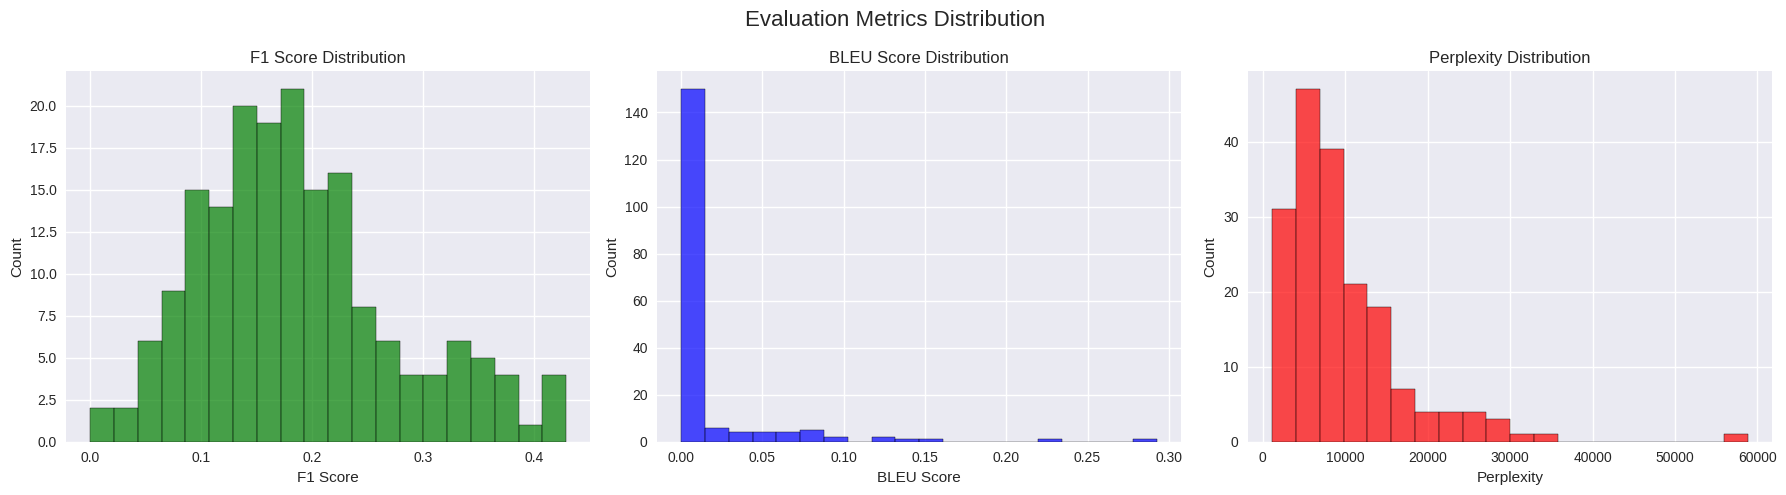


 Evaluation complete


In [33]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, T5ForConditionalGeneration
from sklearn.metrics import f1_score
import evaluate
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

# Fallback Config class
try:
    from configuration import Config
except ModuleNotFoundError:
    class Config:
        MODEL_DIR = "fitness_qa_model"
        DATA_DIR = "processed_data"
        MAX_INPUT_LENGTH = 512
        MAX_TARGET_LENGTH = 64
        LOGS_DIR = "logs"
        FITNESS_KEYWORDS = [
            'exercise', 'workout', 'fitness', 'nutrition', 'muscle', 'cardio', 'strength',
            'yoga', 'running', 'sleep', 'stress', 'recovery', 'flexibility', 'balance',
            'posture', 'hydration', 'motivation', 'diet', 'weight', 'training', 'gym',
            'health', 'stretch', 'protein', 'calorie', 'endurance', 'aerobic', 'anaerobic'
        ]

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def normalize_answer(text: str) -> str:
    """
    Normalize text for F1 score computation.
    
    Args:
        text: Input text to normalize.
    
    Returns:
        str: Normalized text.
    """
    text = re.sub(r'\b(a|an|the)\b', ' ', text.lower())
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    return ' '.join(text.split())

def compute_f1(pred: str, true: str) -> float:
    """
    Compute F1 score between predicted and true text.
    
    Args:
        pred: Predicted text.
        true: True text.
    
    Returns:
        float: F1 score.
    """
    pred_tokens = normalize_answer(pred).split()
    true_tokens = normalize_answer(true).split()
    common = set(pred_tokens) & set(true_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * (precision * recall) / (precision + recall)

def plot_evaluation_metrics(f1_scores: list, bleu_scores: list, perplexities: list) -> None:
    """
    Plot histograms of evaluation metrics.
    
    Args:
        f1_scores: List of F1 scores.
        bleu_scores: List of BLEU scores.
        perplexities: List of perplexity values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Evaluation Metrics Distribution', fontsize=16)
    
    sns.histplot(f1_scores, bins=20, ax=axes[0], color='green', alpha=0.7)
    axes[0].set_title('F1 Score Distribution')
    axes[0].set_xlabel('F1 Score')
    
    sns.histplot(bleu_scores, bins=20, ax=axes[1], color='blue', alpha=0.7)
    axes[1].set_title('BLEU Score Distribution')
    axes[1].set_xlabel('BLEU Score')
    
    sns.histplot(perplexities, bins=20, ax=axes[2], color='red', alpha=0.7)
    axes[2].set_title('Perplexity Distribution')
    axes[2].set_xlabel('Perplexity')
    
    plt.tight_layout()
    plt.savefig(f"{Config.LOGS_DIR}/evaluation_metrics.png")
    plt.show()
    logger.info(f"Evaluation metrics plot saved to {Config.LOGS_DIR}/evaluation_metrics.png")

def evaluate_model(model_path: str = os.path.join(Config.MODEL_DIR, "final"), 
                   val_data_path: str = os.path.join(Config.DATA_DIR, "validation_dataset.csv")) -> dict:
    """
    Evaluate the trained T5 model using BLEU, F1, and perplexity metrics.
    
    Args:
        model_path: Path to the trained model.
        val_data_path: Path to validation dataset.
    
    Returns:
        dict: Evaluation metrics (BLEU, F1, perplexity).
    
    Raises:
        FileNotFoundError: If model or data files are missing.
    """
    print("\n===  Model Evaluation ===")
    
    # Log current working directory
    logger.info(f"Current working directory: {os.getcwd()}")
    
    # Validate file paths
    logger.info(f"Checking model path: {model_path}")
    logger.info(f"Checking data path: {val_data_path}")
    
    if not os.path.exists(model_path):
        logger.error(f"Model directory not found: {model_path}")
        raise FileNotFoundError(f"Model directory not found: {model_path}")
    if not os.path.exists(os.path.join(model_path, "config.json")):
        logger.error(f"Model config file missing in: {model_path}")
        raise FileNotFoundError(f"Model config file missing in: {model_path}")
    if not os.path.exists(val_data_path):
        logger.error(f"Validation data file not found: {val_data_path}")
        raise FileNotFoundError(f"Validation data file not found: {val_data_path}")
    
    # Load model and tokenizer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
        model.eval()
        logger.info(f"Loaded model from {model_path} on {device}")
    except Exception as e:
        logger.error(f"Failed to load model: {e}")
        raise RuntimeError(f"Failed to load model: {e}")
    
    # Load validation data
    try:
        val_df = pd.read_csv(val_data_path)
        logger.info(f"Loaded validation data with {len(val_df)} samples")
    except Exception as e:
        logger.error(f"Failed to load validation data: {e}")
        raise RuntimeError(f"Failed to load validation data: {e}")
    
    # Initialize evaluation
    bleu = evaluate.load("bleu")
    preds, refs, f1_scores, bleu_scores, perplexities = [], [], [], [], []
    
    with torch.no_grad():
        for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Evaluating"):
            prompt = f"Answer this fitness question: {row['Question']}"
            try:
                inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=Config.MAX_INPUT_LENGTH).to(device)
                labels = tokenizer(row['Answer'], return_tensors='pt', truncation=True, max_length=Config.MAX_TARGET_LENGTH).input_ids.to(device)
                
                # Generate prediction
                outputs = model.generate(**inputs, max_length=Config.MAX_TARGET_LENGTH, num_beams=5, no_repeat_ngram_size=2)
                decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
                preds.append(decoded)
                refs.append([row['Answer']])
                f1_scores.append(compute_f1(decoded, row['Answer']))
                
                # Compute BLEU score
                bleu_result = bleu.compute(predictions=[decoded], references=[[row['Answer']]])['bleu']
                bleu_scores.append(bleu_result)
                
                # Compute perplexity
                logits = model(**inputs, labels=labels).logits
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                                     shift_labels.view(-1), ignore_index=tokenizer.pad_token_id)
                perplexities.append(np.exp(loss.item()))
            except Exception as e:
                logger.warning(f"Error processing row {idx}: {e}")
                continue
    
    # Aggregate metrics
    metrics = {
        'bleu_score': np.mean(bleu_scores) if bleu_scores else 0.0,
        'f1_score': np.mean(f1_scores) if f1_scores else 0.0,
        'perplexity': np.mean(perplexities) if perplexities else float('inf')
    }
    
    print(f"🔹 BLEU Score: {metrics['bleu_score']:.4f}")
    print(f"🔹 F1 Score: {metrics['f1_score']*100:.2f}%")
    print(f"🔹 Perplexity: {metrics['perplexity']:.2f}")
    
    # Visualize metrics
    if f1_scores and bleu_scores and perplexities:
        plot_evaluation_metrics(f1_scores, bleu_scores, perplexities)
    
    return metrics

if __name__ == "__main__":
    try:
        metrics = evaluate_model()
        print("\n Evaluation complete")
    except Exception as e:
        print(f" Evaluation failed: {e}")

In [ ]:
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
import logging
import os
import re
import sys

# Fallback Config class
try:
    from configuration import Config
except ModuleNotFoundError:
    class Config:
        # Update to absolute path if issues persist, e.g., "/absolute/path/to/fitness_qa_model"
        MODEL_DIR = "fitness_qa_model"
        MAX_INPUT_LENGTH = 512
        MAX_TARGET_LENGTH = 64
        LOGS_DIR = "logs"
        FITNESS_KEYWORDS = [
            'exercise', 'workout', 'fitness', 'nutrition', 'muscle', 'cardio', 'strength',
            'yoga', 'running', 'sleep', 'stress', 'recovery', 'flexibility', 'balance',
            'posture', 'hydration', 'motivation', 'diet', 'weight', 'training', 'gym',
            'health', 'stretch', 'protein', 'calorie', 'endurance', 'aerobic', 'anaerobic',
            'core', 'abs', 'squats', 'deadlift', 'bench', 'pull', 'push', 'rep', 'set',
            'rest', 'form', 'technique', 'injury', 'rehabilitation', 'supplement'
        ]

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class FitnessChatbot:
    """
    A chatbot for answering fitness-related questions using a fine-tuned T5 model.
    """
    def __init__(self, model_path: str = os.path.join(Config.MODEL_DIR, "final")):
        self.model_path = model_path
        self.fallback_path = "processor/final"  # Fallback for previous runs
        self.max_input_length = Config.MAX_INPUT_LENGTH
        self.max_target_length = Config.MAX_TARGET_LENGTH
        self.fitness_keywords = Config.FITNESS_KEYWORDS
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = None
        self.model = None
        logger.info(f"Initializing chatbot with model at {model_path} (fallback: {self.fallback_path}) on {self.device}")
        logger.info(f"Current working directory: {os.getcwd()}")

    def check_model_files(self) -> dict:
        """
        Check which model files are available in the model directory.
        
        Returns:
            dict: Status of required files
        """
        file_status = {
            'model_dir_exists': os.path.exists(self.model_path),
            'config_exists': False,
            'model_weights_exist': False,
            'tokenizer_exists': False,
            'model_file_type': None,
            'available_files': []
        }
        
        if file_status['model_dir_exists']:
            available_files = os.listdir(self.model_path)
            file_status['available_files'] = available_files
            
            # Check for config file
            file_status['config_exists'] = 'config.json' in available_files
            
            # Check for model weights (either format)
            if 'pytorch_model.bin' in available_files:
                file_status['model_weights_exist'] = True
                file_status['model_file_type'] = 'pytorch_model.bin'
            elif 'model.safetensors' in available_files:
                file_status['model_weights_exist'] = True
                file_status['model_file_type'] = 'model.safetensors'
            
            # Check for tokenizer files
            tokenizer_files = ['tokenizer.json', 'tokenizer_config.json', 'special_tokens_map.json']
            file_status['tokenizer_exists'] = any(tf in available_files for tf in tokenizer_files)
        
        return file_status

    def load_model(self) -> bool:
        """
        Load the fine-tuned T5 model and tokenizer.
        
        Returns:
            bool: True if loaded successfully, False otherwise.
        """
        print("\n=== Chatbot Setup ===")
        
        # Try primary model path
        file_status = self.check_model_files()
        
        if not file_status['model_dir_exists']:
            logger.warning(f"Model directory not found: {self.model_path}. Trying fallback: {self.fallback_path}")
            self.model_path = self.fallback_path
            file_status = self.check_model_files()
            
            if not file_status['model_dir_exists']:
                logger.error(f"Fallback model directory not found: {self.model_path}")
                print(f" Model directory not found: {self.model_path} or {self.fallback_path}")
                print("Please ensure Cell 11 saved the model to 'fitness_qa_model/final/'.")
                print("Run: `ls -l fitness_qa_model/final/` to verify files.")
                return False
        
        print(f" Found model directory: {self.model_path}")
        print(f" Available files: {file_status['available_files']}")
        
        if not file_status['config_exists']:
            logger.error(f"Config file missing in: {self.model_path}")
            print(" config.json file missing")
            return False
        
        if not file_status['model_weights_exist']:
            logger.error(f"Model weights file missing in: {self.model_path}")
            print(" Model weights file missing (neither pytorch_model.bin nor model.safetensors found)")
            return False
        
        if not file_status['tokenizer_exists']:
            logger.warning(f"Tokenizer files may be missing in: {self.model_path}")
            print(" Tokenizer files may be missing, but attempting to load...")
        
        print(f"✅ Found model weights: {file_status['model_file_type']}")
        
        try:
            print("⏳ Loading tokenizer...")
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_path, local_files_only=True)
            print(" Tokenizer loaded successfully")
            
            print("⏳ Loading model...")
            self.model = T5ForConditionalGeneration.from_pretrained(self.model_path, local_files_only=True).to(self.device)
            self.model.eval()
            print(" Model loaded successfully")
            
            # Get model info
            param_count = sum(p.numel() for p in self.model.parameters())
            print(f" Model parameters: {param_count:,}")
            
            logger.info(f"Model and tokenizer loaded successfully from {self.model_path}")
            return True
            
        except Exception as e:
            logger.error(f"Failed to load model: {e}")
            print(f" Failed to load model: {e}")
            print("\n Debug Information:")
            print(f"   - Model path: {self.model_path}")
            print(f"   - Available files: {file_status['available_files']}")
            print(f"   - PyTorch version: {torch.__version__}")
            print(f"   - Device: {self.device}")
            print("Run: `ls -l fitness_qa_model/final/` to verify files.")
            return False

    def is_fitness_related(self, question: str) -> bool:
        """
        Check if the question is related to fitness based on keywords.
        
        Args:
            question: User input question.
        
        Returns:
            bool: True if fitness-related, False otherwise.
        """
        question_lower = question.lower()
        # Remove punctuation and split into words for better matching
        words = re.findall(r'\b\w+\b', question_lower)
        question_text = ' '.join(words)
        
        # Check for direct keyword matches
        keyword_match = any(keyword in question_text for keyword in self.fitness_keywords)
        
        # Also check for common fitness question patterns
        fitness_patterns = [
            r'\b(how to|how do i|what.* best|should i|can i|is it good)\b.*\b(exercise|workout|train|lose weight|gain muscle)\b',
            r'\b(muscle|strength|cardio|protein|calories|diet|nutrition)\b',
            r'\b(gym|fitness|health|weight|running|yoga)\b'
        ]
        
        pattern_match = any(re.search(pattern, question_text) for pattern in fitness_patterns)
        
        return keyword_match or pattern_match

    def generate_response(self, question: str) -> str:
        """
        Generate a response to a fitness question.
        
        Args:
            question: User input question.
        
        Returns:
            str: Generated response or error message.
        """
        if not self.model or not self.tokenizer:
            return " Error: Model not loaded. Please ensure the model is set up correctly."
        
        if not self.is_fitness_related(question):
            return ("🏃‍♀️ I'm a fitness specialist! I can help with questions about exercise, nutrition, "
                   "workouts, health, and wellness. Please ask me something fitness-related!")

        prompt = f"Answer this fitness question: {question}"
        try:
            inputs = self.tokenizer(
                prompt,
                return_tensors='pt',
                truncation=True,
                max_length=self.max_input_length,
                padding=True
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=self.max_target_length,
                    num_beams=4,
                    no_repeat_ngram_size=2,
                    early_stopping=True,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=self.tokenizer.pad_token_id
                )
            
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # Clean up the response
            response = response.strip()
            if response.startswith("Answer this fitness question:"):
                response = response.replace("Answer this fitness question:", "").strip()
            
            logger.info(f"Generated response for question: {question[:50]}...")
            return f" {response}" if response else " I'm not sure about that. Could you rephrase your question?"
            
        except Exception as e:
            logger.error(f"Failed to generate response: {e}")
            return f" Error generating response: {str(e)}"

    def get_sample_questions(self) -> list:
        """
        Return a list of sample questions users can ask.
        """
        return [
            "What are the best exercises for core strength?",
            "How much protein do I need daily?",
            "What's a good beginner workout routine?",
            "How often should I do cardio?",
            "What foods are good for muscle recovery?",
            "How do I improve my running endurance?",
            "What are the benefits of strength training?",
            "How much water should I drink during workouts?"
        ]

    def start_chat(self) -> None:
        """
        Start an interactive chat session with the user.
        """
        print("\n" + "="*50)
        print("🏋️‍♀️ FITNESS AI CHATBOT 🏋️‍♂️")
        print("="*50)
        print("Ask me any fitness-related question! Type 'quit' to exit.")
        print("Type 'help' for sample questions or 'info' for chatbot details.")
        
        if not self.load_model():
            print("\n Chatbot cannot start due to model loading failure.")
            print("\n Troubleshooting steps:")
            print("1. Make sure you've run Cell 11 to train the model.")
            print("2. Check that 'fitness_qa_model/final/' exists: `ls -l fitness_qa_model/final/`")
            print("3. Verify model files (config.json, pytorch_model.bin, tokenizer.json).")
            print("4. Run: `df -h .` to check disk space and `chmod -R u+w fitness_qa_model/` for permissions.")
            return
        
        print("\n🎉 Chatbot is ready! Ask your first fitness question:")
        
        while True:
            try:
                question = input("\n💬 You: ").strip()
                
                if question.lower() in ['quit', 'exit', 'bye']:
                    print("\n Thanks for using the Fitness AI Chatbot! Stay healthy!")
                    break
                    
                elif question.lower() == 'help':
                    print("\n📝 Here are some sample questions you can ask:")
                    for i, sample in enumerate(self.get_sample_questions(), 1):
                        print(f"   {i}. {sample}")
                    continue
                    
                elif question.lower() == 'info':
                    print(f"\n Chatbot Info:")
                    print(f"   - Model: T5 fine-tuned for fitness Q&A")
                    print(f"   - Device: {self.device}")
                    print(f"   - Model path: {self.model_path}")
                    continue
                
                if not question:
                    print("Please enter a valid question.")
                    continue
                
                print("⏳ Thinking...")
                response = self.generate_response(question)
                print(f" Bot: {response}")
                
            except KeyboardInterrupt:
                print("\n\n Goodbye!")
                break
            except Exception as e:
                print(f" An error occurred: {e}")
                logger.error(f"Chat error: {e}")

def main():
    """
    Main function to run the fitness chatbot.
    """
    try:
        # Log sys.argv for debugging
        logger.info(f"Command-line arguments: {sys.argv}")
        
        # Check if running in Jupyter to warn about unexpected arguments
        if 'ipykernel' in sys.modules:
            logger.warning("Running in Jupyter. Unexpected sys.argv values may cause path issues.")
            print(" Running in Jupyter. Ensure no unintended command-line arguments (e.g., '-f').")
        
        # Validate custom model path
        model_path = os.path.join(Config.MODEL_DIR, "final")
        if len(sys.argv) > 1:
            custom_path = sys.argv[1]
            if os.path.isdir(custom_path) and custom_path != '-f':
                model_path = custom_path
                print(f" Using custom model path: {model_path}")
            else:
                logger.warning(f"Invalid custom model path: {custom_path}. Using default: {model_path}")
                print(f" Invalid custom model path: {custom_path}. Using default: {model_path}")
        
        chatbot = FitnessChatbot(model_path)
        chatbot.start_chat()
        
    except Exception as e:
        print(f" Chatbot failed to start: {e}")
        logger.error(f"Main execution failed: {e}")

if __name__ == "__main__":
    main()

 Running in Jupyter. Ensure no unintended command-line arguments (e.g., '-f').
 Invalid custom model path: -f. Using default: fitness_qa_model/final

🏋️‍♀️ FITNESS AI CHATBOT 🏋️‍♂️
Ask me any fitness-related question! Type 'quit' to exit.
Type 'help' for sample questions or 'info' for chatbot details.

=== Chatbot Setup ===
 Found model directory: fitness_qa_model/final
 Available files: ['generation_config.json', 'spiece.model', 'tokenizer_config.json', 'training_args.bin', 'tokenizer.json', 'special_tokens_map.json', 'model.safetensors', 'config.json']
✅ Found model weights: model.safetensors
⏳ Loading tokenizer...
 Tokenizer loaded successfully
⏳ Loading model...
 Model loaded successfully
 Model parameters: 60,506,624

🎉 Chatbot is ready! Ask your first fitness question:



💬 You:   How can I improve my core strength?


⏳ Thinking...
 Bot:  you can improve your core strength by improving your strength and strength. if youre looking for a workout that suits your needs, you should be able to do it yourself.



💬 You:  how do i prevent overtraining and burnout?


⏳ Thinking...
 Bot:  you can prevent overtraining and burnout by using a combination of physical and mental health tools.
